In [4]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco

### 1. Neural Networks

### Visualizing the data

In [4]:
data = loadmat("ex4data1.mat")

In [6]:
X = data["X"]
X.shape, X[:5]

((5000, 400),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [7]:
y = data["y"][:,0]
y.shape

(5000,)

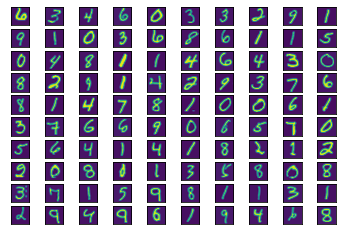

In [8]:
for i in range(100):
    plt.subplot(10, 10, i + 1)
    # Take random datapoints as they are ordered
    plt.imshow(X[np.random.randint(X.shape[0]),:].reshape(20,20).T)
    plt.xticks([])
    plt.yticks([])    

### Model representation

In [6]:
data = loadmat("ex4weights.mat")
tset = loadmat("ex4data1.mat")

In [7]:
X, y = tset["X"], tset["y"]
yt = np.zeros((y.shape[0],10))
for i in range(y.shape[0]):
    idx = y[i]-1
    yt[i,idx] = 1
X = np.hstack((np.ones((X.shape[0], 1)), X))
th1, th2 = data["Theta1"], data["Theta2"]

###  Feedforward and cost function

In [104]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def h(th1, th2, X):
    a_1 = sigmoid(np.dot(th1,X.T))
    a_1 = a_1.T
    a_1 = np.hstack((np.ones((a_1.shape[0], 1)), a_1))
    h = sigmoid(np.dot(th2,a_1.T))
    return h

def J(ths, X, y, lam):
    j = -(np.multiply(y.T,np.log(h(ths[0], ths[1],X))) + np.multiply(1-y.T,np.log(1-h(ths[0], ths[1],X)))).sum()
    j += lam/2*(np.multiply(ths[0][:,1:], ths[0][:,1:]).sum()+np.multiply(ths[1][:,1:], ths[1][:,1:]).sum())
    j /= y.shape[0]
    return j
    
print(f"{J([th1, th2], X, yt, lam=0):.6f}")

0.287629


### Regularized cost function

In [105]:
print(f"{J([th1, th2], X, yt, lam=1):.6f}")

0.383770


### 2. Backpropagation

### Sigmoid gradient

0.25

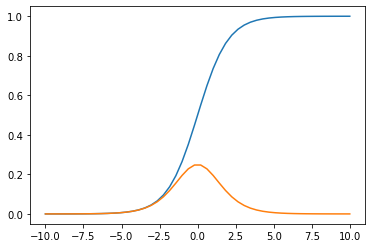

In [109]:
def grad_s(z):
    return sigmoid(z)*(1-sigmoid(z))
z = np.linspace(-10,10)
plt.plot(z, sigmoid(z), label="Sigmoid")
plt.plot(z, grad_s(z), label="Sigmoid gradient")

grad_s(0)

### Random initialization

In [10]:
def randInit(eps, shape):
    return np.random.uniform(-eps,eps, shape)
eps = .12
data = loadmat("ex4weights.mat")
th1, th2 = randInit(eps, data["Theta1"].shape),randInit(eps, data["Theta2"].shape)

In [126]:
def contInit(shape):
    da = np.zeros(shape)
    da = np.reshape(np.sin(np.arange(da.size)), da.shape)/10.
    return da

### Backpropagation

In [18]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def grad_s(z):
    return sigmoid(z)*(1-sigmoid(z))

def forw_prop(th1,th2,X):
    a_1 = X
    a_2 = sigmoid(np.dot(th1,a_1.T))
    a_2 = a_2.T
    a_2 = np.hstack((np.ones((a_2.shape[0], 1)), a_2))
    a_3 = sigmoid(np.dot(th2,a_2.T))
    return a_1, a_2, a_3

def back_prop(th1,th2,X,y, lam):
    m = y.shape[0]
    a_1, a_2, a_3 = forw_prop(th1,th2,X)
    d_3 = a_3.T-y
    
    d_2 = np.dot(d_3, th2)*grad_s(a_2)
    d_2 = d_2[:,1:]
    
    d_1 = np.dot(d_2, th1)*grad_s(a_1)
    d_1 = d_1[:,1:]    
    
    D_2 = np.dot(d_3.T,a_2)/m+lam/m*th2
    D_1 = np.dot(d_2.T,a_1)/m+lam/m*th1
    return D_1, D_2

### Gradient Checking

In [188]:
def J(ths, X, y, lam):
    h = forw_prop(ths[0],ths[1],X)[-1]
    j = -(np.multiply(y.T,np.log(h)) + np.multiply(1-y.T,np.log(1-h))).sum()
    j += lam/2*(np.multiply(ths[0][:,1:], ths[0][:,1:]).sum()+np.multiply(ths[1][:,1:], ths[1][:,1:]).sum())
    j /= y.shape[0]
    return j

def num_deriv(X, y, th1, th2, eps, lam):
    f1 = np.zeros_like(th1)
    f2 = np.zeros_like(th2)
    for k,th in enumerate([th1,th2]):
        pert = np.zeros_like(th)
        #Could be written better
        for i in range(th.shape[0]):
            for j in range(th.shape[1]):
                pert[i,j] = eps
                if k==0:
                    f = J([th+pert, th2], X, y, lam)-J([th-pert, th2], X, y, lam)
                    f1[i,j] = f/2/eps
                if k==1:
                    f = J([th1, th+pert], X, y, lam)-J([th1, th-pert], X, y, lam)
                    f2[i,j] = f/2/eps
                pert[i,j] = 0
    return f1,f2

In [177]:
# Andrew works with a controlled "random" here, much easier that before
inp_layer_s = 3
hid_layer_s = 5
out_layer_s = 3
set_s = 5

th1 = contInit((hid_layer_s, inp_layer_s+1))
th2 = contInit((out_layer_s, hid_layer_s+1))
X = contInit((set_s, inp_layer_s))
X = np.hstack((np.ones((X.shape[0], 1)), X))
y = 1 + np.mod(np.arange(set_s), out_layer_s)
yt = np.zeros((y.shape[0],out_layer_s))
for i in range(y.shape[0]):
    idx = y[i]-1
    yt[i,idx] = 1
    
D_1, D_2 = back_prop(th1, th2, X, yt)
f_1, f_2 = num_deriv(X, yt, th1, th2, eps=1e-4)

In [182]:
D_1[:2], f_1[:2]

(array([[ 6.49186236e-03, -1.04165567e-04,  1.35092261e-04,
          2.50146888e-04],
        [ 1.14650530e-02, -4.03820567e-05,  1.42952689e-04,
          1.94857392e-04]]),
 array([[ 6.90654083e-03, -1.10852711e-04,  1.43851835e-04,
          2.66299665e-04],
        [ 1.21251043e-02, -4.29822045e-05,  1.51666184e-04,
          2.06873385e-04]]))

### Regularized Neural Networks

In [193]:
data = loadmat("ex4weights.mat")
tset = loadmat("ex4data1.mat")

In [194]:
X, y = tset["X"], tset["y"]
yt = np.zeros((y.shape[0],10))
for i in range(y.shape[0]):
    idx = y[i]-1
    yt[i,idx] = 1
X = np.hstack((np.ones((X.shape[0], 1)), X))
th1, th2 = data["Theta1"], data["Theta2"]

In [195]:
lam = 3
check_grads = num_deriv(X, yt, th1, th2, eps=1e-4, lam=lam)
cost = J([th1,th2], X, yt, lam)
cost

0.5760512469501331

### Learning parameters using scipy

In [24]:
def Jmin(ths, X, y, lam, t1_sh, t2_sh):
    th1 = ths[:(t1_sh[0]*t1_sh[1])].reshape(t1_sh)
    th2 = ths[(t1_sh[0]*t1_sh[1]):].reshape(t2_sh)
    h = forw_prop(th1,th2,X)[-1]
    j = -(np.multiply(y.T,np.log(h)) + np.multiply(1-y.T,np.log(1-h))).sum()
    j += lam/2*(np.multiply(th1[:,1:], th1[:,1:]).sum()+np.multiply(th2[:,1:], th2[:,1:]).sum())
    j /= y.shape[0]
    return j

def forw_prop(th1,th2,X):
    a_1 = X
    a_2 = sigmoid(np.dot(th1,a_1.T))
    a_2 = a_2.T
    a_2 = np.hstack((np.ones((a_2.shape[0], 1)), a_2))
    a_3 = sigmoid(np.dot(th2,a_2.T))
    return a_1, a_2, a_3

def back_prop_min(ths,X,y, lam,t1_sh, t2_sh):
    th1 = ths[:(t1_sh[0]*t1_sh[1])].reshape(t1_sh)
    th2 = ths[(t1_sh[0]*t1_sh[1]):].reshape(t2_sh)
    m = y.shape[0]
    a_1, a_2, a_3 = forw_prop(th1,th2,X)
    d_3 = a_3.T-y
    
    d_2 = np.dot(d_3, th2)*grad_s(a_2)
    d_2 = d_2[:,1:]
    
    d_1 = np.dot(d_2, th1)*grad_s(a_1)
    d_1 = d_1[:,1:]    
    
    D_2 = np.dot(d_3.T,a_2)/m+lam/m*th2
    D_1 = np.dot(d_2.T,a_1)/m+lam/m*th1
    Dc =  np.hstack((D_1.ravel(), D_2.ravel()))
#     Dc =  np.array(list(D_1.ravel())+list(D_2.ravel()))
    return Dc

In [25]:
data = loadmat("ex4weights.mat")
tset = loadmat("ex4data1.mat")

In [26]:
X, y = tset["X"], tset["y"]
yt = np.zeros((y.shape[0],10))
for i in range(y.shape[0]):
    idx = y[i]-1
    yt[i,idx] = 1
X = np.hstack((np.ones((X.shape[0], 1)), X))
th1_0, th2_0 = randInit(eps, data["Theta1"].shape),randInit(eps, data["Theta2"].shape)

In [29]:
import scipy.optimize as sco

ths = np.array(list(th1_0.ravel())+list(th2_0.ravel()))
th1s = data["Theta1"].shape
th2s = data["Theta2"].shape
lam=1
mini = sco.minimize(Jmin,x0=ths, method='CG', args=(X,yt,lam,th1s,th2s), jac=back_prop_min, options={'maxiter':50})
mini # Success is false but accuracy is still high

     fun: 1.1477527557285319
     jac: array([ 2.00996222e-03, -2.02329077e-05,  9.54758231e-06, ...,
       -1.12626901e-05,  6.16951512e-03,  3.14786504e-03])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 104
     nit: 19
    njev: 92
  status: 2
 success: False
       x: array([ 0.01361233, -0.10116454,  0.04773791, ...,  1.79781804,
        1.22066464, -1.22539293])

In [30]:
th1_opt = mini.x[:(th1s[0]*th1s[1])].reshape(th1s)
th2_opt = mini.x[(th1s[0]*th1s[1]):].reshape(th2s)
h = forw_prop(th1_opt,th2_opt,X)[-1]
h.max()
# print(np.mean(h == y.T))

pred = np.zeros_like(h)
print(h.shape)
for i in range(h.shape[1]):
    argg = np.argwhere(h[:,i]==np.max(h[:,i]))[0][0]
    pred[argg,i]=1
acc = np.array(pred == yt.T, dtype='int').mean()
acc

(10, 5000)


0.96992